In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import timedelta
from scipy import stats
import scipy.stats as ss
from scipy.stats import norm

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [2]:
df = pd.read_csv('Проект_1_Задание_2.csv', sep=';')

In [3]:
df.head(5)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [4]:
df.shape

(404770, 3)

In [5]:
df.user_id.nunique()

404770

In [6]:
arpu = df.groupby('testgroup', as_index=False).agg({'user_id': 'count', 'revenue': 'sum'})

In [7]:
arpu['arpu'] = round(arpu.revenue / arpu.user_id, 2)

In [8]:
arpu
# а - контрольная группа, б - тестовая

,testgroup,user_id,revenue,arpu
0,a,202103,5136189,25.41
1,b,202667,5421603,26.75


In [9]:
#Расчет ARPPU (доход на платящего пользователя)
arppu = df.query('revenue != 0').groupby('testgroup', as_index=False).agg({'user_id': 'count', 'revenue': 'sum'})

In [10]:
arppu['arppu'] = round(arppu.revenue / arppu.user_id, 2)

In [11]:
arppu

,testgroup,user_id,revenue,arppu
0,a,1928,5136189,2664.00
1,b,1805,5421603,3003.66


ARPPU в тестовой группе на 12% больше, чем в контрольной

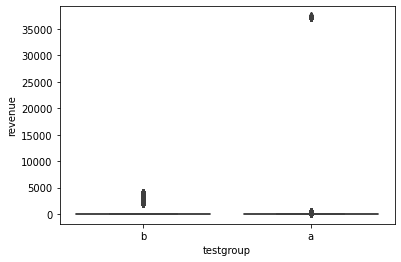

In [12]:
# Пробую построить боксплот и посмотреть распределение ARPU
sns.boxplot(x='testgroup', y='revenue', data=df)

В контрольной группе имеется заметный выброс

In [13]:
# В тестовой группе максимальный доход на пользователя - 4000
df.query('testgroup == "b"').sort_values('revenue', ascending = False).head(5)

,user_id,revenue,testgroup
149618,149619,4000,b
34357,34358,4000,b
185454,185455,3999,b
36472,36473,3999,b
47825,47826,3995,b


In [14]:
# В контрольной группе 123 пользователя, у которых доход превышает 4000
df.query('testgroup == "a" and revenue > 4000').sort_values('revenue', ascending = False)

,user_id,revenue,testgroup
101861,101862,37433,a
196601,196602,37407,a
65077,65078,37394,a
21585,21586,37385,a
142804,142805,37379,a
...,...,...,...
81477,81478,37294,a
254113,254114,37294,a
34534,34535,37294,a
235858,235859,37294,a


Пользователей с очень высоким чеком достоточно много, чтобы предполагать, что крупные суммы - результат ошибки. Однако все же не понятно, что это за группа покупателей, которая потратила очень большие суммы

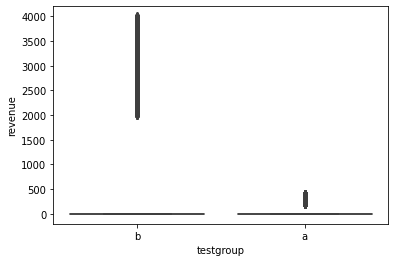

In [15]:
# Строю боксплот, чтобы посмотреть распределение без учета "дорогих" покупателей
sns.boxplot(x='testgroup', y='revenue', data=df.query('revenue <= 4000'))

Если исключить пользователей с очень высоким чеком (которые были в контрольной группе), то по графику видно, что в тестовой группе чек значительно выше, чем в контрольной

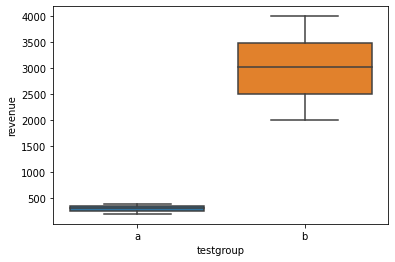

In [16]:
# Боксплот ARPPU по группам без учета "дорогих" покупателей
sns.boxplot(x='testgroup', y='revenue', data=df.query('revenue > 0 and revenue <= 4000'))

Если исключить пользователей с очень высоким чеком (которые были в контрольной группе), а также оставить только платящих пользователей, то график также показывает, что в тестовой группе чек значительно выше, чем в контрольной.
Так, в контрольной чек не превышает 500, а в тестовой начинается с 2000

In [17]:
print(df.query('testgroup == "b" and revenue > 0').revenue.mean(), # среднее в тестовой группе
      df.query('testgroup == "a" and revenue > 0 and revenue < 4000').revenue.mean(), # среднее в контрольной группе без выбросов
      df.query('testgroup == "a" and revenue > 0').revenue.mean()) # среднее в контрольной группе

3003.6581717451522 302.45817174515236 2663.9984439834025


Интересно, что благодаря выбросам, среднее в контрольной группе приближается к значению среднего в тестовой группе

In [18]:
print(df.query('testgroup == "b" and revenue > 0').revenue.median(), # медиана в тестовой группе
      df.query('testgroup == "a" and revenue > 0 and revenue < 4000').revenue.median(), # медиана в контрольной группе без выбросов
      df.query('testgroup == "a" and revenue > 0').revenue.median()) # медиана в контрольной группе

3022.0 305.0 311.0


В случаях с выбросами лучше ориетироваться на медиану, а не на среднее

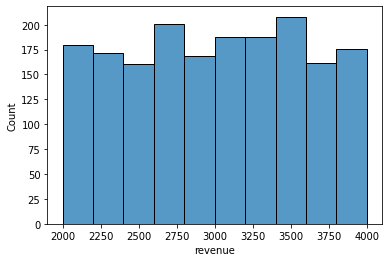

In [19]:
sns.histplot(data = df.query('testgroup == "b" and revenue > 0'), x = 'revenue', bins=10)

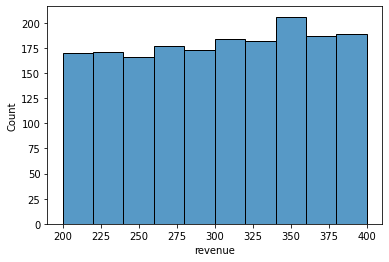

In [20]:
sns.histplot(data = df.query('testgroup == "a" and revenue > 0 and revenue < 4000'), x = 'revenue', bins=10)

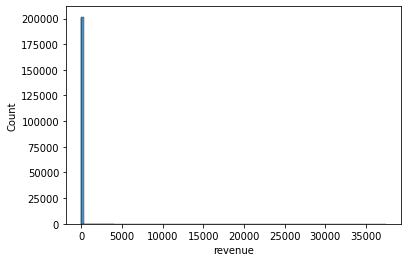

In [21]:
sns.histplot(data = df.query('testgroup == "b"'), x = 'revenue', bins=100)
sns.histplot(data = df.query('testgroup == "a"'), x = 'revenue', bins=100)

Сравнивать данные по ARPU кажется не совсем правильным, так как очень большое количество нулевых значений может негативно повлиять на нахождение стат.значимых различий

Решаю провести несколько тестов (как с учетом, так и без учета больших чеков - выбросов) и сравнить ARPPU в тестовой и контрольной группах

# T-тест

In [22]:
print(np.var(df.query('testgroup == "b" and revenue > 0').revenue),
      np.var(df.query('testgroup == "a" and revenue > 0 and revenue < 4000').revenue), 
      np.var(df.query('testgroup == "a" and revenue > 0').revenue))

327711.673181145 3352.2017130009745 81842649.10425068


Дисперсии в группах сильно различаются

In [23]:
# На полных данных
stats.ttest_ind(df[(df.testgroup == "a") & (df.revenue > 0)].revenue,
df[(df.testgroup == "b") & (df.revenue > 0)].revenue,
equal_var=False)

Ttest_indResult(statistic=-1.6446302664300838, pvalue=0.10020780398916015)

p-value значительно больше 0,05 -> тест не показал стат.значимых различий

In [24]:
# Без учета выбросов
stats.ttest_ind(df[(df.testgroup == "a") & (df.revenue <= 4000) & (df.revenue > 0)].revenue,
df[(df.testgroup == "b") & (df.revenue > 0)].revenue,
equal_var=False)

Ttest_indResult(statistic=-199.39722533995328, pvalue=0.0)

Тест обнаружил стат.значимые различия, что позволяет отклонить нулевую гипотезу о равенстве средних

# Тест Манна-Уитни

In [25]:
# На полных данных
stats.mannwhitneyu(df[(df.testgroup == "a") & (df.revenue > 0)].revenue,
df[(df.testgroup == "b") & (df.revenue > 0)].revenue,
alternative = 'two-sided')

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

In [26]:
# Без учета выбросов
stats.mannwhitneyu(df[(df.testgroup == "a") & (df.revenue <= 4000) & (df.revenue > 0)].revenue,
df[(df.testgroup == "b") & (df.revenue > 0)].revenue,
alternative = 'two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

В обоих случаях тест Манна-Уитни показал наличие стат.значимых различий, что позволяет отклонить нулевую гипотезу о равенстве распределений как между тестом и контролем с выбросами, так и между тестом и контролем без выбросов

# Сравнение средних и медиан через бутстрап

In [27]:
def get_bootstrap(data_column_1, data_column_2, boot_it = 1000, statistic = np.mean, bootstrap_conf_level = 0.95):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in range(boot_it):
        samples_1 = data_column_1.sample(boot_len, replace = True).values
        samples_2 = data_column_2.sample(boot_len, replace = True).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    p_1 = norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
    p_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2
       
    return {"p_value": p_value}

In [28]:
# На полных данных
x = df[(df.testgroup == "b") & (df.revenue > 0)].revenue
y = df[(df.testgroup == "a") & (df.revenue > 0)].revenue

npmean = get_bootstrap(x, y)
npmedian = get_bootstrap(x, y, statistic = np.median)
    
print(f'Boot mean: {npmean["p_value"]}, Boot median: {npmedian["p_value"]}')

Boot mean: 0.10461034725487596, Boot median: 0.0


In [29]:
# Без учета выбросов
x = df[(df.testgroup == "b") & (df.revenue > 0)].revenue
y = df[(df.testgroup == "a") & (df.revenue <= 4000) & (df.revenue > 0)].revenue

npmean = get_bootstrap(x, y)
npmedian = get_bootstrap(x, y, statistic = np.median)
    
print(f'Boot mean: {npmean["p_value"]}, Boot median: {npmedian["p_value"]}')

Boot mean: 0.0, Boot median: 0.0


# Выводы

Для принятия решения была проанализирована метрика ARPPU, которая, в отличие от ARPU, принимает во внимание только платящих пользователей.

ARPPU в тестовой группе оказался на 12% больше, чем в контрольной.

Вместе с тем, в контрольной группе были обнаружены выбросы, природу которых необходимо исследовать.
Интересно, что благодаря выбросам, среднее в контрольной группе приблизилось к значению среднего в тестовой группе.

Были проведены стат.тесты: Т-тест, тест Манна-Уитни, Бутстрап.

Т-тест на полных данных показал отсутствие различий, что можно объяснить тем, что средние в тестовой группе и контрольной с выбросами достаточно близки.
Т-тест на данных без выбросов показал наличие стат.значимых различий между тестом и контролем.

Тест Манна-Уитни в обоих случаях показал, что распределения тестовой и контрольных групп неравны.

Сравнение средних через бутстрап показало различные результаты для групп с учетом и без учета выбросов (так же как и в Т-тесте).
Однако бутстрап по медиане дает нам основания для отклонения нулевой гипотезы, так как p-value в обоих случаях сильно меньше 0.05.

В целом, можно сделать вывод о том, что изменения, примененные к тестовой группе, статистически значимо увеличили ARPPU. 
Однако перед тем, как раскатывать изменения на всех пользователей, необходимо изучить причину возникновения чрезмерно высоких чеков у ряда пользователей из контрольной группы.